<div style='background-color: #fff3cd; border: 1px solid #ffeaa7; border-radius: 4px; padding: 15px; margin: 10px 0; border-left: 4px solid #f39c12;'>
<h3 style='color: #856404; margin-top: 0;'>⚠️ EXECUTION WARNING</h3>
<p style='color: #856404; margin-bottom: 0;'><strong>This notebook may not execute properly in the current environment.</strong></p>
<p style='color: #856404; margin-bottom: 0;'>Some cells may have failed during automated testing. Please review the notebook content and test manually before use.</p>
<p style='color: #856404; margin-bottom: 0; font-size: 0.9em;'><em>Generated during CI/CD pipeline - some outputs may be incomplete or missing.</em></p>
</div>


<a id="title"></a>
# Synthetic Photometry Examples for WFC3
<hr>
## Learning Goals

By the end of this tutorial, you will: 

- Specify WFC3 bandpasses in `stsynphot` and define spectra with `synphot`.
- Compute WFC3 zeropoint values and an encircled energy correction.
- Renormalize a spectrum and predict its effective stimulus in another filter.
- Find the photometric transformation between two bandpasses.
- Find the UV color term across the two UVIS chips for different spectral types.
- Plot bandpasses and spectra.

## Table of Contents

[Introduction](#intro) <br>
[1. Imports](#imports) <br>
[2. Bandpasses and spectra](#band_spec) <br>
- [2.1 Set up bandpasses](#band) <br>
- [2.2 Define spectra](#spec) <br>

[3. Examples](#ex) <br>
- [Example 1a: Compute the inverse sensitivity and zeropoint](#e1) <br>
- [Example 1b: Compute an encircled energy correction](#e1b) <br>
- [Example 2:  Renormalize a spectrum and predict its effective stimulus in another filter](#e2) <br>
- [Example 3:  Find the photometric transformation between two bandpasses](#e3) <br>
- [Example 4a: Find the UV color term across the two UVIS chips for different spectral types](#e4) <br>
- [Example 4b: Plot bandpasses and spectra](#e4b)

[4. Conclusions](#conclusion) <br>
[Additional Resources](#resources) <br>
[About the Notebook](#about) <br>
[Citations](#cite) <br>

<a id="intro"></a>
## Introduction

This notebook contains several examples of how to use the `synphot` and `stsynphot` modules for various photometric purposes. 

`synphot` is a Python module that facilitates synthetic photometry, which has an extension module called `stsynphot` to add support for STScI missions. `synphot` is meant to be a replacement for AstroLib `pysynphot`. 

Examples 1, 2, and 3 are based on those found in Section 9.1.10 of the 2018 version of the WFC3 Data Handbook. 

`stsynphot` requires access to data distributed by the [Calibration Data Reference System](https://hst-crds.stsci.edu/) (CRDS) in order to operate. Both packages look for an environment variable called `PYSYN_CDBS` to find the directory containing these data.

Users can obtain these data files from the CDRS. Information on how to obtain the most up-to-date reference files (and what they contain) can be found [here](https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/synphot-throughput-tables). An example of how to download the files with `curl` and set up this environment variable is presented below.

For detailed instructions on how to install and set up these packages, see the [synphot](https://synphot.readthedocs.io/en/latest/#installation-and-setup) and [stsynphot](https://stsynphot.readthedocs.io/en/latest/#installation-and-setup) documentation.

<a id="imports"></a>
## 1. Imports

This notebook assumes you have created the virtual environment in [WFC3 Library's](https://github.com/spacetelescope/WFC3Library) installation instructions.

We import:
- *os* for setting environment variables

- *numpy* for handling array functions
- *matplotlib.pyplot* for plotting data

- *synphot* and *stsynphot* for evaluating synthetic photometry
- *astropy.units* and *synphot.units* for handling units

Additionally, we will need to set the `PYSYN_CDBS` environment variable *before* importing stsynphot. We will also create a Vega spectrum using synphot's inbuilt `from_vega()` method, as the latter package will supercede this method's functionality and require a downloaded copy of the latest Vega spectrum to be provided.

In [1]:
%matplotlib inline

import os
import tarfile

import numpy as np
import matplotlib.pyplot as plt

import synphot as syn

from astropy import units as u
from synphot import units as su

vegaspec = syn.SourceSpectrum.from_vega()

This section obtains the WFC3 throughput component tables for use with `stsynphot`. This step only needs to be done once. If these reference files have already been downloaded, this section can be skipped.

In [2]:
!curl -O https://archive.stsci.edu/hlsps/reference-atlases/hlsp_reference-atlases_hst_multi_everything_multi_v11_sed.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0  796M    0 98304    0     0   236k      0  0:57:29 --:--:--  0:57:29  235k

  7  796M    7 55.8M    0     0  44.8M      0  0:00:17  0:00:01  0:00:16 44.8M

 18  796M   18  149M    0     0  66.0M      0  0:00:12  0:00:02  0:00:10 66.0M

 29  796M   29  238M    0     0  73.1M      0  0:00:10  0:00:03  0:00:07 73.1M

 40  796M   40  326M    0     0  76.8M      0  0:00:10  0:00:04  0:00:06 76.8M

 51  796M   51  410M    0     0  77.9M      0  0:00:10  0:00:05  0:00:05 84.3M

 60  796M   60  482M    0     0  77.2M      0  0:00:10  0:00:06  0:00:04 85.3M

 70  796M   70  558M    0     0  77.0M      0  0:00:10  0:00:07  0:00:03 82.0M

 80  796M   80  637M    0     0  77.2M      0  0:00:10  0:00:08  0:00:02 79.8M

 89  796M   89  715M    0     0  77.3M      0  0:00:10  0:00:09  0:00:01 77.8M

100  796M  100  796M    0     0  77.8M      0  0:00:10  0:00:10 --:--:-- 77.7M


Once the downloaded is complete, extract the file and set the environment variable `PYSYN_CDBS` to the path of the `trds` subdirectory.  The next cell will do this for you, as long as the `.tar` file downloaded above has not been moved.

In [3]:
tar_archive = 'hlsp_reference-atlases_hst_multi_everything_multi_v11_sed.tar'
extract_to = 'hlsp_reference-atlases_hst_multi_everything_multi_v11_sed'
abs_extract_to = os.path.abspath(extract_to)

with tarfile.open(tar_archive, 'r') as tar:
    for member in tar.getmembers():
        member_path = os.path.abspath(os.path.join(abs_extract_to, member.name))
        if member_path.startswith(abs_extract_to):
            tar.extract(member, path=extract_to)   
        else:
            print(f"Skipped {member.name} due to potential security risk")

os.environ['PYSYN_CDBS'] = os.path.join(abs_extract_to, 'grp/redcat/trds/')

Now, after having set up `PYSYN_CDBS`, we import stsynphot. A warning regarding the Vega spectrum is expected here.

In [4]:
import stsynphot as stsyn

## 2. Bandpasses and spectra  <a class="anchor" id="band_spec"></a>

### 2.1 Set up bandpasses <a class="anchor" id="band"></a>

All of the examples below require us to define a bandpass. Bandpasses are defined in `stsynphot` using a string of comma-separated keywords that represents a particular observation mode (obsmode). For WFC3, an obsmode string will, at minimum, look something like: `"wfc3, [detector], [filter]"`. E.g. `"wfc3, uvis1, f606w"` will get you the bandpass for the F606W filter on WFC3's UVIS1 detector. One may also specify an aperture size in arcseconds with `aper#value` and a Modified Julian Date (to account for time-dependent changes in the UVIS detector sensitivity) with `mjd#value`.

The documentation [here](https://stsynphot.readthedocs.io/en/latest/stsynphot/obsmode.html) provides a further overview of how to construct an observation mode, and includes a link to the full set of available obsmode keywords.

### 2.2 Define spectra <a class="anchor" id="spec"></a>

Examples 2-4 require us to define a spectrum. Examples for generating some commonly useful spectra using `synphot` are embedded here:


```python
# Blackbody
bb_temp = 5800 * u.K

model = syn.models.BlackBody1D(bb_temp)
spec  = syn.SourceSpectrum(model)

# Power law 
pl_index = 0

model = syn.models.PowerLawFlux1D(amplitude=flux_in, x_0=wl_in, alpha=pl_index)
spec  = syn.SourceSpectrum(model)
                                  
# Load from a FITS table (e.g. a CALSPEC spectrum)
spec = syn.SourceSpectrum.from_file('/path/to/your/spectrum.fits')
```

Note:

- `synphot.models.BlackBody1D` outputs a function according to Planck's law, which means that the output unit carries an *implicit* "per unit solid angle," in steradians. `BlackBodyNorm1D`, outputs a spectrum that is normalized to a 1 solar radius star at a distance of 1 kpc.

- `synphot.models.PowerLawFlux1D` uses the definition $ f(x) = A (\frac{x}{x_0})^{-\alpha} $. We pass `flux_in` as $A$, and `wl_in` as $x_0$. Note the negative sign in front of the power law index $\alpha$. The model can generate curves with $x$ as either frequency or wavelength, but the example here assumes that wavelength will be used. The y-axis unit will be taken from $A$. 

- A wide array of reference spectra are available for download from spectral atlases located [here](https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs).

<a id="ex"></a>
## 3. Examples

<a class="anchor" id="e1"></a>
### Example 1a: Compute the inverse sensitivity and zeropoint 
**Compute inverse sensitivity (PHOTFLAM) and zeropoint values (STmag, ABmag, and Vegamag) for F814W on UVIS1 in an infinite (6.0”) aperture.**

This example should reproduce the values found in Table 6 of [WFC3 ISR 2021-04](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/WFC3_ISR_2021-04.pdf), the relevant row of which is reproduced here:

| Filter 	| Pivot Wavelength 	| PHOTFLAM   	| STMAG  	| ABMAG  	| VEGAMAG 	|
|:--------	|:-----------------	|:------------	|:--------	|:--------	|:---------	|
| F814W  	| 8039.1 Å         	| 1.4980e-19 	| 25.961 	| 25.127 	| 24.699  	|

We include the keywords `'aper#6.0'` and `'mjd#55008'` in our obsmode string to match the aperture and reference epoch used for the calculations in this ISR.

The WFC3 Zeropoints notebook, which can be found in the [WFC3 Library](https://github.com/spacetelescope/WFC3Library), contains an example to perform this calculation iteratively over all UVIS and IR bandpasses and to compute 'total system throughput tables' for each mode.

First, we set up a bandpass based on our observation mode. 

In [5]:
obsmode = 'wfc3, uvis1, f814w, aper#6.0, mjd#55008'
bp = stsyn.band(obsmode)

Then, we can find the unit response for the bandpass, which is the flux (in $\text{erg } \text{cm}^{-2} \text{ s}^{-1} \text{ Å}^{-1}$, aka FLAM) that produces 1 electron per second. For this calculation, we must pass the HST primary mirror area. 

In [6]:
uresp = bp.unit_response(stsyn.conf.area)

Next, we convert the unit response to magnitudes in the ST and AB systems. For the AB conversion, we need the bandpass pivot wavelength.

In [7]:
st = -2.5 * np.log10(uresp.value) - 21.1  

pivot = bp.pivot()                        # Pivot wavelength for ABmag conversion
ab = st - 5 * np.log10(pivot.value) + 18.6921

Converting the unit response for the bandpass to the vegamag system requires us to generate a synthetic Observation, which consists of Vega's spectrum convolved with the bandpass.

In [8]:
obs = syn.Observation(vegaspec, bp, binset=bp.binset)
effstim = obs.effstim(flux_unit=su.FLAM)  # Effective stimulus for Vega observation
ve = -2.5 * np.log10(uresp/effstim)       # vegamag sensitivity value

Now, we can print our results.

In [9]:
print('Obsmode:', obsmode)
print('Pivot Wavelength: {:.1f}'.format(pivot))
print()
print('PHOTFLAM: {:.6}'.format(uresp))
print('STmag:    {:.3f}'.format(st))
print('ABmag:    {:.3f}'.format(ab))
print('VEGAMAG:  {:.3f}'.format(ve))

Obsmode: wfc3, uvis1, f814w, aper#6.0, mjd#55008
Pivot Wavelength: 8039.1 Angstrom

PHOTFLAM: 1.49941e-19 FLAM
STmag:    25.960
ABmag:    25.126
VEGAMAG:  24.698


<a class="anchor" id="e1b"></a>
### Example 1b: Compute an encircled energy correction

As an addendum to the previous example, we can calculate the unit response for the same bandpass, but with a ~10 pixel aperture (0.4"), and compute the encircled energy correction, in magnitudes, with respect to the infinite aperture. 

First, we set up the new bandpass for the smaller aperture size.

In [10]:
obsmode_04 = 'wfc3, uvis1, f814w, aper#0.4, mjd#55008'  # Set obsmode string
bp_04 = stsyn.band(obsmode_04)

Then, we find the unit response for the new bandpass.

In [11]:
uresp_04 = bp_04.unit_response(stsyn.conf.area)

Finally, we convert the unit response to a magnitude in the ST system, and find the difference between it and the corresponding value for the infinite aperture. This represents the encircled energy correction from 10 pixels to infinity.

In [12]:
st_04 = -2.5 * np.log10(uresp_04.value) - 21.1

st_eecorr = st - st_04

print('EE Correction (10 pixels -> infinity): {:.3f}'.format(st_eecorr), 'mag')

EE Correction (10 pixels -> infinity): 0.110 mag


<a class="anchor" id="e2"></a>
### Example 2: Renormalize a spectrum and predict its magnitude in another bandpass
**Renormalize a 2,500 K blackbody spectrum to have 1 count/sec in the Johnson V band, and compute the predicted AB magnitude through the F110W filter on WFC3/IR.**

This example reproduces the methods described in section 3 of [WFC3 ISR 2014-16](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2014/WFC3-2014-16.pdf), but will automatically use the latest available spectra and throughput tables.

First, we define a Johnson V bandpass to which we normalize our spectrum.

In [13]:
vband = stsyn.band('johnson, v')

Then, we define the output bandpass for the calculation.

In [14]:
obsmode = 'wfc3, ir, f110w'
bp = stsyn.band(obsmode)

Next, we choose a 2500 K blackbody model, fit our spectrum to the model, and use the `normalize` method to normalize the spectrum to one count/sec in the V band.

In [15]:
model = syn.models.BlackBody1D(2500)
spec = syn.SourceSpectrum(model)
spec_norm = spec.normalize(1*u.ct, vband, area=stsyn.conf.area)

Finally, we generate a synthetic Observation, which consists of the normalized spectrum convolved with the bandpass, and print the predicted flux (in FLAM) and ABmag values for our Observation.

In [16]:
obs = syn.Observation(spec_norm, bp)

flux = obs.effstim(flux_unit=su.FLAM)
ab = obs.effstim(flux_unit=u.ABmag)

print('Predicted flux:  {:.4}  for Obsmode = {}'.format(flux, obsmode))
print('Predicted ABmag: {:.3f}  for Obsmode = {}'.format(ab, obsmode))

Predicted flux:  5.113e-19 FLAM  for Obsmode = wfc3, ir, f110w
Predicted ABmag: 23.010 mag(AB)  for Obsmode = wfc3, ir, f110w


<a class="anchor" id="e3"></a>
### Example 3: Find the photometric transformation between two bandpasses
**Find the color term for a 5,000 K blackbody between the Cousins-I and WFC3/UVIS1 F814W bandpasses in the ABmag system.**

More examples may be found in the filter transformations notebook in the [WFC3 Library](https://github.com/spacetelescope/WFC3Library).

First, we set up two bandpasses based on our observation modes. 

In [17]:
obsmode1 = 'wfc3, uvis1, f814w'
obsmode2 = 'cousins, i'

bp1 = stsyn.band(obsmode1)
bp2 = stsyn.band(obsmode2)

Then, we choose a 5000 K blackbody model and fit our spectrum to the model.

In [18]:
model = syn.models.BlackBody1D(5000.)
spec = syn.SourceSpectrum(model)

Next, we generate two synthetic Observations, which consists of the blackbody spectrum convolved with the bandpass.

In [19]:
obs1 = syn.Observation(spec, bp1, binset=bp1.binset)
obs2 = syn.Observation(spec, bp2, binset=bp2.binset)

Finally, we calculate the color term by finding the difference between the two effective stimuli in ABmag.

In [20]:
stim1 = obs1.effstim(flux_unit=u.ABmag)
stim2 = obs2.effstim(flux_unit=u.ABmag)

color = stim2 - stim1

print('ABmag({}) - ABmag({}) = {:.4f}'.format(obsmode2, obsmode1, color))

ABmag(cousins, i) - ABmag(wfc3, uvis1, f814w) = 0.0054 mag


<a class="anchor" id="e4"></a>
### Example 4a: Find the UV color term across the two UVIS chips for different spectral types
**Calculate the UV color terms (in the STmag system) for a white dwarf spectrum and a G-type spectrum across the two UVIS chips with the F225W filter. Then, find the difference between these two terms to find the magnitude offset on UVIS2 for the G-type star.**

This example reproduces the results from Figure 4 of [WFC3 ISR 2018-08](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2018/WFC3-2018-08.pdf).

The spectra required to run this example, which are the latest relevant spectra from CALSPEC, are provided in the `example_spectra` sub-directory which was packaged with this notebook.

First, we set up two bandpasses based on our observation modes, and define our area to be the HST primary mirror area.

In [21]:
obsmode1 = 'wfc3, uvis1, f225w'
obsmode2 = 'wfc3, uvis2, f225w'

bp1 = stsyn.band(obsmode1)
bp2 = stsyn.band(obsmode2)

Then, we define our spectra from the provided FITS files.

In [22]:
spec_wd = syn.SourceSpectrum.from_file('example_spectra/gd153_stiswfcnic_003.fits') # GD153 (white dwarf)
spec_g = syn.SourceSpectrum.from_file('example_spectra/p330e_stiswfcnic_003.fits') # P330E (G-type)

Next, we generate four synthetic Observations, one for each spectrum in each bandpass. Ignore the warning messages.

In [23]:
obs1_wd = syn.Observation(spec_wd, bp1, binset=bp1.binset, force='extrap')
obs2_wd = syn.Observation(spec_wd, bp2, binset=bp2.binset, force='extrap')

obs1_g = syn.Observation(spec_g, bp1, binset=bp1.binset, force='extrap')
obs2_g = syn.Observation(spec_g, bp2, binset=bp1.binset, force='extrap')

Following this, we calculate the effective stimuli (in STmag) for these Observations, and find the difference between these values across the two chips for each spectral type.

In [24]:
stim1_wd = obs1_wd.effstim(flux_unit=u.STmag)
stim2_wd = obs2_wd.effstim(flux_unit=u.STmag)

stim1_g = obs1_g.effstim(flux_unit=u.STmag)
stim2_g = obs2_g.effstim(flux_unit=u.STmag)

dstim_wd = stim1_wd - stim2_wd
dstim_g = stim1_g - stim2_g

Finally, we calculate the overall cross-chip color term for the G-type star by finding its offset from the white dwarf.

In [25]:
print('Color Term (UVIS1 - UVIS2): {:.3f}'.format(dstim_g - dstim_wd))

Color Term (UVIS1 - UVIS2): -0.073 mag


<a class="anchor" id="e4b"></a>
### Example 4b: Plot bandpasses and spectra

**Create a plot with the bandpasses and spectra used in Example 4a.**

**Note:** For the purposes of these plots, the spectra will be scaled to the amplitude of the bandpasses, which reflect the actual total system throughput as a function of wavelength. You will see that the throughput is different between the two chips.

First, define a set of wavelengths and a minimum/maximum bound for our plot, based on the average wavelength and witdth of the bandpasses.

In [26]:
avgwave = (bp1.avgwave().to(u.nm) + bp2.avgwave().to(u.nm))/2
width = (bp1.rectwidth().to(u.nm) + bp2.rectwidth().to(u.nm))/2

left = max((avgwave - 1.5 * width).value, 1)
right = (avgwave + 1.5 * width).value

wl = np.arange(left, right) * u.nm

Next, scale the spectra to the (average) amplitude of the bandpasses.

In [27]:
avg_max = (np.max(bp1(wl)) + np.max(bp2(wl))) / 2
scale_wd = avg_max / np.max(spec_wd(wl))
scale_g = avg_max / np.max(spec_g(wl))

spec_wd_scale = spec_wd(wl) * scale_wd
spec_g_scale = spec_g(wl) * scale_g

Then, plot the bandpasses and spectra.

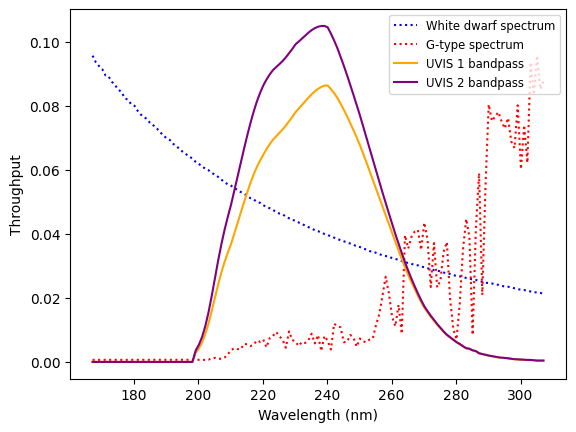

In [28]:
plt.figure()

plt.xlabel('Wavelength (nm)')
plt.ylabel('Throughput')

plt.plot(wl, spec_wd_scale, ls=':', c='blue', label='White dwarf spectrum')
plt.plot(wl, spec_g_scale, ls=':', c='red', label='G-type spectrum')
plt.plot(wl, bp1(wl), ls='-', c='orange', label='UVIS 1 bandpass')
plt.plot(wl, bp2(wl), ls='-', c='purple', label='UVIS 2 bandpass')

plt.legend(fontsize='small')

plt.show()

<a id="conclusion"></a>
## 4. Conclusions

Thank you for walking through this notebook. Now using WFC3 data, you should be more familiar with:

- Specify WFC3 bandpasses in `stsynphot` and define spectra with `synphot`.
- Computing WFC3 zeropoint values and an encircled energy correction.
- Renormalizing a spectrum and predict its effective stimulus in another filter.
- Finding the photometric transformation between two bandpasses.
- Finding the UV color term across the two UVIS chips for different spectral types.
- Plotting bandpasses and spectra.

#### Congratulations, you have completed the notebook!

<a id="resources"></a>
## Additional Resources
Below are some additional resources that may be helpful. Please send any questions through the [HST Helpdesk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
    - see sections 9.5.2 for reference to this notebook
    
<a id="about"></a>
## About this Notebook

**Authors:** Aidan Pidgeon, Jennifer Mack; WFC3 Instrument Team

**Updated on:** 2021-09-14

<a id="cite"></a>
## Citations

If you use `numpy`, `astropy`, `synphot`, or `stsynphot` for published research, please cite the
authors. Follow these links for more information about citing the libraries below:

* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `synphot`](https://synphot.readthedocs.io/en/latest/)
* [Citing `stsynphot`](https://stsynphot.readthedocs.io/en/latest/index.html)

<hr>

[Top of Page](#title)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/hst_notebooks/main/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 